## TEMPERATURE FORECASTING USING SEQUENTIAL MODELS

In [1]:
#imports

# general imports
from IPython.display import display, Markdown #just to display markdown
import numpy as np  #for vector operation
import string   # provides strings variations for character embedding
import os

# keras imports
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


# visualiaztion imports
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


### TEMPERATURE FORECASTING PROBLEM
#### PROBLEM STATEMENT

dataset: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

Given data going as far back as lookback timesteps (a timestep is 10 minutes) and 
sampled every steps timesteps, can we predict the temperature in delay timesteps?

We will use the following parameter values:

lookback = 1440, i.e. our observations will go back 10 days.
steps = 6, i.e. our observations will be sampled at one data point per hour. 
delay = 144, i.e. our targets will be 24 hour in the future.

### TRAINING DATA

In [2]:
# path to the data
fname = '/home/sj-ai-lsb/Documents/datasets/jena_climate/jena_climate_2009_2016.csv'

# reading the data file
f = open(fname)
data = f.read()
f.close()

# reading the headers and the content
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

display(Markdown("### Data summary \n"))
print ("\nData contains {} columns\n".format(len(header)))
print(header)

print("\nData has {} samples for training and testing\n".format(len(lines)))
print("3 sample data points")
print(lines[:3])

#data pre-processing
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # omiting first column date & time
    float_data[i, :] = values

print("\nconverting data to numpy array(omiting first column date & time)\n")
print (float_data[:3])
print("\ndata shape: rows {}, columns {}\n".format(float_data.shape[0],float_data.shape[1]))

### Data summary 



Data contains 15 columns

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']

Data has 420551 samples for training and testing

3 sample data points
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30', '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10', '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']

converting data to numpy array(omiting first column date & time)

[[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
   3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
   1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]
 [ 9.96570e+02 -8.41000e+00  2.65010e+02 -9.28000e+00  9.34000e+01
   3.23000e+00  3.02

### PLOTTING TEMP VS TIME

### temperature plot across years & 10 days

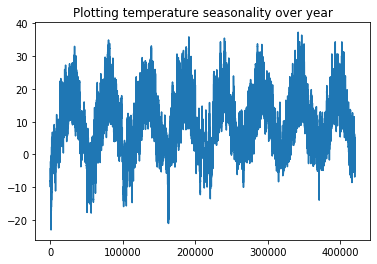

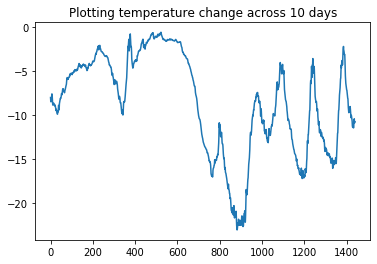

In [3]:
temp = float_data[:, 1]  # temperature (in degrees Celsius)

display(Markdown("### temperature plot across years & 10 days"))

# plotting temperature across years
plt.plot(range(len(temp)), temp)
plt.title('Plotting temperature seasonality over year')

plt.figure()

#plotting temperature for first 10 days collected every 10 mins a day(144 data points/day)
plt.plot(range(1440), temp[:1440])
plt.title('Plotting temperature change across 10 days')
plt.show()

### DATA PREPARATION

In [4]:
# pre-processing
display(Markdown("### data normalization"))

print("\n data before normalization\n")
print (float_data[:3])

float_data_ = float_data
mean = float_data_[:200000].mean(axis=0) # calcaulating mean of first 200K samples for each columns
float_data_ -= mean  # substracting the mean from each element in the column
std = float_data_[:200000].std(axis=0) # calcaulating standard deviation of first 200K samples  for each columns
float_data_ /= std  # normalizing each element in the column with the standard deviation of the columns

print("\n data after normalization\n")
print (float_data[:3])
print("\n data shape: rows {}, columns {}\n".format(float_data.shape[0],float_data.shape[1]))

### data normalization


 data before normalization

[[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
   3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
   1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]
 [ 9.96570e+02 -8.41000e+00  2.65010e+02 -9.28000e+00  9.34000e+01
   3.23000e+00  3.02000e+00  2.10000e-01  1.89000e+00  3.03000e+00
   1.30980e+03  7.20000e-01  1.50000e+00  1.36100e+02]
 [ 9.96530e+02 -8.51000e+00  2.64910e+02 -9.31000e+00  9.39000e+01
   3.21000e+00  3.01000e+00  2.00000e-01  1.88000e+00  3.02000e+00
   1.31024e+03  1.90000e-01  6.30000e-01  1.71600e+02]]

 data after normalization

[[ 0.90014748 -1.93135845 -1.98211036 -1.86280029  1.07285236 -1.30742164
  -1.47375773 -0.79868641 -1.4762674  -1.47815522  2.12375056 -0.72950452
  -0.78067973 -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    -1.91582958  1.07883061 -1.32042698
  -1.4951961  -0.80075238 -1.49502455 -1.49932141  2.17199852 -0.93124017
  -0.88794488 -0.46317443]
 [ 0.90132666 -1.98671006

In [5]:
#creating a custom generator (prepares training, validation and test data as per problem statement)
#Now here is the data generator that we will use. It yields a tuple (samples, targets) 
#where samples is one batch of input data and targets is the corresponding array of target temperatures

"""
data: The original array of floating point data, which we just normalized in the code snippet above.

lookback(measured in timesteps) : How many timesteps back should our input data go. 

delay(measured in timesteps) : How many timesteps in the future should our target be. 

min_index and max_index: Indices in the data array that delimit which timesteps to draw from. 
This is useful for keeping a segment of the data for validation and another one for testing.

shuffle: Whether to shuffle our samples or draw them in chronological order. 

batch_size: The number of samples per batch.

step(measured in timesteps) : The period, in timesteps, at which we sample data. 
We will set it 6 in order to draw one data point every hour 
"""

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:

            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

### lets underatand this data preparation w.r.t problem statement

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

# sample generator for understanding the data preparation
undertansing_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

print ("""
Problem statement:
Given data going as far back as lookback timesteps (a timestep is 10 minutes) and 
sampled every steps timesteps, can we predict the temperature in delay timesteps?

We will use the following parameter values:

lookback = 1440, i.e. our observations will go back 10 days.
steps = 6, i.e. our observations will be sampled at one data point per hour. 
delay = 144, i.e. our targets will be 24 hour in the future.

Variable understanding:
lookback = 1440 timesteps (1 timesteps == 10 minutes)
Therefore lookback = 1440 * 10 minutes
i.e lookback = (1440 * 10)/60 hours
i.e lookback = (1440 * 10)/(60*24) days = 10 days


similarly,

step = 6 timestamp = 6 * 10 minutes = 1 hour  
delay = 144 timestamps = (144*10)/(60*24) = 1 day

""")

print ("""Note: to understand the concept of yield and generator.
visit: https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do
""")

print ("""Understanding first batch\n""")
for value in undertansing_gen:
    first_batch_samples, first_batch_target = value
    break

print ("First batch data sample shape is {}".format(first_batch_samples.shape))
print ("""128 : batch-size
240 : number of sample collected (in lookback timestamp's 10 days). 
Note: Not all 1440 sample colleted, only (timestamps in lookback)/(steps) = 1440/6 = 240 
14  : number of columns in data """)

display(Markdown("### 1 data sample"))
print (first_batch_samples[0])

print ("\nFirst batch target shape is {}".format(first_batch_target.shape))
print ("""128 : '128' temperature values for each batch.
Note: temperature values 1 day ahead in furture(as per delay = 1 day) are collected """)
display(Markdown("### 5 target sample"))
print (first_batch_target[:4])


Problem statement:
Given data going as far back as lookback timesteps (a timestep is 10 minutes) and 
sampled every steps timesteps, can we predict the temperature in delay timesteps?

We will use the following parameter values:

lookback = 1440, i.e. our observations will go back 10 days.
steps = 6, i.e. our observations will be sampled at one data point per hour. 
delay = 144, i.e. our targets will be 24 hour in the future.

Variable understanding:
lookback = 1440 timesteps (1 timesteps == 10 minutes)
Therefore lookback = 1440 * 10 minutes
i.e lookback = (1440 * 10)/60 hours
i.e lookback = (1440 * 10)/(60*24) days = 10 days


similarly,

step = 6 timestamp = 6 * 10 minutes = 1 hour  
delay = 144 timestamps = (144*10)/(60*24) = 1 day


Note: to understand the concept of yield and generator.
visit: https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do

Understanding first batch

First batch data sample shape is (128, 240, 14)
128 : batch-size
240 : number of sample

### 1 data sample

[[ 0.7810498  -1.27730586 -1.32536501 ...  1.2292835   0.66954518
  -1.69220145]
 [ 0.79048327 -1.3529907  -1.40131515 ...  1.50260276  0.99563125
  -1.62627619]
 [ 0.80817105 -1.38574981 -1.43482257 ...  2.1924085   1.61347854
  -1.54649623]
 ...
 [-2.7918806  -0.97795536 -0.75797276 ... -0.89870216 -0.67341457
   0.9361499 ]
 [-2.78598468 -1.05476983 -0.83503982 ... -1.23709743 -1.30842429
  -1.85129955]
 [-2.80603082 -1.08301044 -0.86184575 ... -0.72950452 -0.7592267
  -1.61830974]]

First batch target shape is (128,)
128 : '128' temperature values for each batch.
Note: temperature values 1 day ahead in furture(as per delay = 1 day) are collected 


### 5 target sample

[-1.20613952 -0.26855117 -0.34084714  1.13557211]


### preparing the training, validation and test generators"

In [7]:
print ("""
the training generator looks at the first 200,000 timesteps, 
the validation generator looks at the following 100,000, & 
the test generator looks at the remainder
""")

lookback = 1440
step = 6
delay = 144
batch_size = 128

#training data preparation
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many batches to draw from `val_gen`
# in order to see the whole validation set:
val_batches = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_batches = (len(float_data) - 300001 - lookback) // batch_size

print ("Number of batches in training: {}".format((200000-lookback)//batch_size))
print ("Number of batches in validation: {}".format(val_batches))
print ("Number of batches in testing: {}".format(test_batches))


the training generator looks at the first 200,000 timesteps, 
the validation generator looks at the following 100,000, & 
the test generator looks at the remainder

Number of batches in training: 1551
Number of batches in validation: 769
Number of batches in testing: 930


### creating non-machine learning baseline

In [8]:
# implementation of baseline model
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_batches):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return(np.mean(batch_maes))
    
print ("""the temperature timeseries can safely be assumed to be continuous 
(the temperatures tomorrow are likely to be close to the temperatures today) 
as well as periodical with a daily period. Thus a common sense approach would be to always 
predict that the temperature 24 hours from now will be equal to the temperature right now
""")

mae = evaluate_naive_method()
print ("baseline yields a MAE of %.2f\n"%(mae))

print ("""Since our temperature data has been normalized to be centered on 0 
and have a standard deviation of one, this number is not immediately interpretable. 
It translates to an average absolute error of 0.29 * temperature_std degrees Celsius, i.e. 2.57°C
""")

celsius_mae = 0.29 * std[1]
print ("temperature deviation in baseline %.2f°C"%(celsius_mae))

the temperature timeseries can safely be assumed to be continuous 
(the temperatures tomorrow are likely to be close to the temperatures today) 
as well as periodical with a daily period. Thus a common sense approach would be to always 
predict that the temperature 24 hours from now will be equal to the temperature right now

baseline yields a MAE of 0.29

Since our temperature data has been normalized to be centered on 0 
and have a standard deviation of one, this number is not immediately interpretable. 
It translates to an average absolute error of 0.29 * temperature_std degrees Celsius, i.e. 2.57°C

temperature deviation in baseline 2.57°C


In [9]:
# function to plot model training logs    
def plot_model_training_history(history,accuracy = True, chart_type="--o"):
        #collecting all post-training values 
        if accuracy:
            acc = history['acc']
            val_acc = history['val_acc']
        loss = history['loss']
        val_loss = history['val_loss']
        epochs = range(1, len(loss) + 1)
        # ploting losses\n",
        plt.plot(epochs, loss, chart_type, label='Training loss')
        plt.plot(epochs, val_loss, chart_type, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
        plt.figure()
        if accuracy:
            # ploting accuracies\n",
            plt.plot(epochs, acc, chart_type, label='Training acc')
            plt.plot(epochs, val_acc, chart_type, label='Validation acc')
            plt.title('Training and validation accuracy')
            plt.legend()
        return

### Training and evaluating a densely-connected model using the data generators

starting model training...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                107552    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 1.2753 - val_loss: 0.6273
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4520 - val_loss: 0.3133
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2906 - val_loss: 0.3029
Epoch 4/20
500/500 [==============================] - 8s 17ms/step -

### result

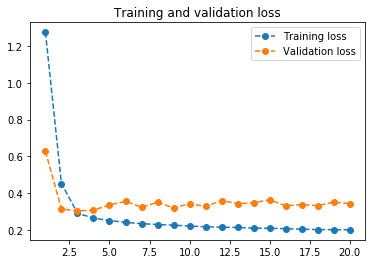

<Figure size 432x288 with 0 Axes>

In [19]:
print("starting model training...")
# model architecture and training
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
print ("\n")
model.summary()
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_batches)

# ploting model training results
display(Markdown("### result"))
plot_model_training_history(history.history,accuracy=False)

### Training and evaluating a GRU-based model

starting model training...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
500/500 [==============================] - 134s 267ms/step - loss: 0.3371 - val_loss: 0.2754
Epoch 2/20
500/500 [==============================] - 132s 265ms/step - loss: 0.3171 - val_loss: 0.2724
Epoch 3/20
500/500 [==============================] - 134s 268ms/step - loss: 0.3107 - val_loss: 0.2745
Epoch 4/20
500/500 [==============================] - 135s 269ms/step - loss: 0.3064 - val_loss: 0.2723
Epoch 5/20
500/500 [==============================] - 134s 269ms/step - loss: 0.3025 - val_

### result

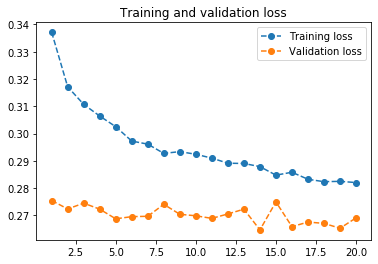

<Figure size 432x288 with 0 Axes>

In [20]:
print("starting model training...")
# model architecture and training
model = Sequential()
model.add(layers.GRU(32,dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
print("\n")
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_batches)

# ploting model training results
display(Markdown("### result"))
plot_model_training_history(history.history,accuracy=False)

### Stacking recurrent layers

starting model training...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 32)          4512      
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________




### result

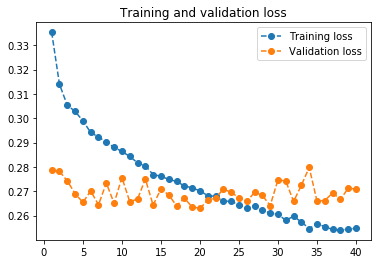

<Figure size 432x288 with 0 Axes>

In [10]:
print("starting model training...")
# model architecture and training
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
print("\n")
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40, verbose=0,
                              validation_data=val_gen,
                              validation_steps=val_batches)

# ploting model training results
display(Markdown("### result"))
plot_model_training_history(history.history,accuracy=False)

### Training a bidirectional GRU

starting model training...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 64)                9024      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________




### result

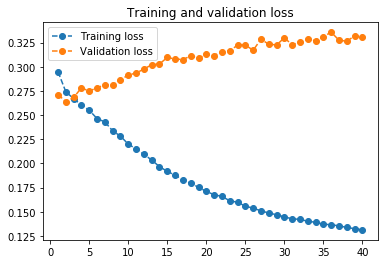

<Figure size 432x288 with 0 Axes>

In [12]:
print("starting model training...")
# model architecture and training
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()
print("\n")

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500, verbose=0,
                              epochs=40,validation_data=val_gen,
                              validation_steps=val_batches)

# ploting model training results
display(Markdown("### result"))
plot_model_training_history(history.history,accuracy=False)

### Training 1D convnet with GRU

starting model training...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
500/500 [==============================] - 58s 116ms/step - loss: 0.3468 - val_loss: 0.2964
Epoch 

### result

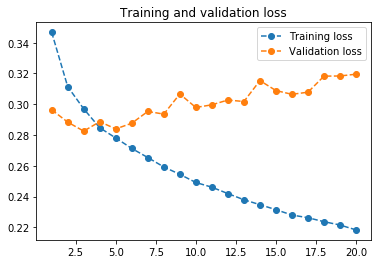

<Figure size 432x288 with 0 Axes>

In [13]:
print("starting model training...")
# model architecture and training

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
print("\n")

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_batches)

# ploting model training results
display(Markdown("### result"))
plot_model_training_history(history.history,accuracy=False)

At this stage, there are still many other things you could try in order to improve 
performance on our weather forecasting problem:

- Adjust the number of units in each recurrent layer in the stacked setup. 
Our current choices are largely arbitrary and thus likely suboptimal.

- Adjust the learning rate used by our RMSprop optimizer. 

- Try using LSTM layers instead of GRU layers.

- Try using a bigger densely-connected regressor on top of the recurrent layers, 
i.e. a bigger Dense layer or even a stack of Dense layers.

- Don’t forget to eventually run the best performing models 
(in terms of validation MAE) on the test set! Least you start developing architectures 
that are overfitting to the validation set.
